In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('hotel_bookings.csv')
data_cln = data.fillna({'children': 0.0, 'country': 'Unknown', 'agent':0, 'company': 0})
data_cln['meal'].replace('Undefined', 'SC', inplace = True)

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])



In [18]:
data.shape

(119390, 32)

In [4]:
resort_data = data_cln[data_cln.hotel == 'Resort Hotel']
city_data = data_cln[data_cln.hotel == 'City Hotel']

In [5]:
def test_model_1():
    inputs = keras.Input(shape=(62,), dtype = "float32")
    
    x = layers.Dense(256)(inputs)
    x = layers.Dense(128)(x)
    x = layers.Dense(64)(x)
    x = layers.Dense(32)(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    model = keras.Model(inputs, outputs)
    # model.summary()

    model.compile("adam", "binary_crossentropy", metrics=["accuracy", "AUC"])
    return model

In [6]:
tmp = test_model_1()

In [7]:
# 10 fold
kfolds = 10 # 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

x = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

x = preprocessor.fit_transform(x)

test_X = x[data_cln.hotel == 'Resort Hotel']
test_Y = y[data_cln.hotel == 'Resort Hotel']

train_X = x[data_cln.hotel == 'City Hotel']
train_Y = y[data_cln.hotel == 'City Hotel']

train_X = train_X.reshape((-1, 62, 1))
test_X = test_X.reshape((-1, 62, 1))
result = []
cr_result = []

for train_index, test_index in split.split(train_Y):
    train_x = train_X[train_index]
    train_y = train_Y[train_index]
    
    test_x = train_X[test_index]
    test_y = train_Y[test_index]
    
    model = test_model_1()
    
    history = model.fit(train_x, train_y, batch_size=64, epochs=30, verbose = 2)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})
    pred_y = model.predict(test_X)
    cr_result.append({'pred': pred_y, 'test': test_Y})

Epoch 1/30
1116/1116 - 36s - loss: 0.4640 - accuracy: 0.7833 - auc: 0.8369
Epoch 2/30
1116/1116 - 37s - loss: 0.4170 - accuracy: 0.8105 - auc: 0.8673
Epoch 3/30
1116/1116 - 38s - loss: 0.4063 - accuracy: 0.8153 - auc: 0.8756
Epoch 4/30
1116/1116 - 37s - loss: 0.3971 - accuracy: 0.8197 - auc: 0.8827
Epoch 5/30
1116/1116 - 38s - loss: 0.3894 - accuracy: 0.8237 - auc: 0.8882
Epoch 6/30
1116/1116 - 36s - loss: 0.3831 - accuracy: 0.8255 - auc: 0.8927
Epoch 7/30
1116/1116 - 37s - loss: 0.3756 - accuracy: 0.8299 - auc: 0.8976
Epoch 8/30
1116/1116 - 38s - loss: 0.3695 - accuracy: 0.8317 - auc: 0.9020
Epoch 9/30
1116/1116 - 38s - loss: 0.3628 - accuracy: 0.8344 - auc: 0.9061
Epoch 10/30
1116/1116 - 36s - loss: 0.3577 - accuracy: 0.8373 - auc: 0.9093
Epoch 11/30
1116/1116 - 38s - loss: 0.3514 - accuracy: 0.8403 - auc: 0.9131
Epoch 12/30
1116/1116 - 37s - loss: 0.3470 - accuracy: 0.8417 - auc: 0.9157
Epoch 13/30
1116/1116 - 37s - loss: 0.3406 - accuracy: 0.8448 - auc: 0.9194
Epoch 14/30
1116/1116

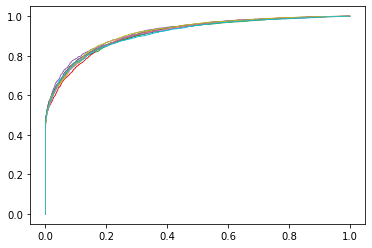

In [8]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('cityEncodeDNN.png')

In [9]:
total_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [10]:
# total
for k, v in total_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.9109538561446691 0.9215769930178888 0.9153108727244754
acc 	 0.8348670112189588 0.8537753687129711 0.8436278835245178
f1 	 0.800178412132025 0.8161082271511719 0.8081613694882923
pre 	 0.9707950243374798 0.9823982398239824 0.9766599902490833
recall 	 1.0 1.0 1.0


In [11]:
total_res

{'auc': [0.9127425560278561,
  0.9144946438733701,
  0.9123793249184939,
  0.9132927341039437,
  0.9215769930178888,
  0.917034775575325,
  0.9145734622138819,
  0.9173224402151211,
  0.9187379411542055,
  0.9109538561446691],
 'acc': [0.843816967099458,
  0.842808521366444,
  0.8414219084835497,
  0.8348670112189588,
  0.8537753687129711,
  0.8475986385982605,
  0.8410437413336694,
  0.8453296356989789,
  0.843312744232951,
  0.8423042984999369],
 'f1': [0.8070388349514561,
  0.8067251461988304,
  0.8055302339714373,
  0.800178412132025,
  0.8161082271511719,
  0.8093023255813953,
  0.8055678957500371,
  0.8100769346809473,
  0.8133053640994905,
  0.8077803203661328],
 'pre': [0.9707950243374798,
  0.9711328976034859,
  0.976464148877942,
  0.9814814814814815,
  0.97675647120972,
  0.97339593114241,
  0.9759373251259094,
  0.9809782608695652,
  0.9772601220188575,
  0.9823982398239824],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [12]:
np.average(total_res['auc'])

0.9153108727244754

In [13]:
np.average(total_res['acc'])

0.8436278835245178

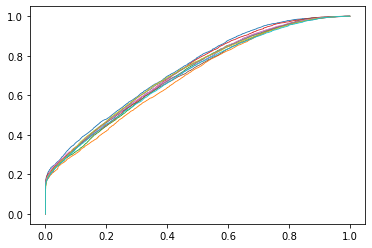

In [14]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = cr_result[i]['pred']
    test = cr_result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('crEncodeDNN.png')

In [19]:
cr_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [20]:
###### total
for k, v in cr_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.6923537978603072 0.7317569192723995 0.7121465020883309
acc 	 0.7651023464802795 0.7745881178232651 0.7692386420369446
f1 	 0.47077316761104004 0.5042409430707303 0.4896122158810024
pre 	 0.8230188679245283 0.8971146545178436 0.8562745196159254
recall 	 1.0 1.0 1.0
